## Image Transformation Pipeline (PyTorch)

Before feeding images into a neural network, we apply a sequence of transformations to ensure they are uniform, normalized, and tensorized. Here’s what each step does:

| Step | Transformation | Purpose | Notes |
|------|----------------|---------|-------|
| 1    | `transforms.Resize((64, 64))` | Resizes all images to 64×64 pixels | Neural networks require fixed-size inputs |
| 2    | `transforms.ToTensor()` | Converts image to PyTorch tensor (and scales pixel values from [0, 255] to [0, 1]) | Changes shape from (H, W, C) to (C, H, W) |
| 3    | `transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])` | Normalizes R, G, B channels to have values in [−1, +1] | Helps model converge faster with zero-centered inputs |

> Together, this pipeline ensures your image data is in the optimal format and scale for training a neural network.


In [1]:
#Transforms:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Subset
from collections import defaultdict
import torch
import random

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3,[0.5]*3)
])

#Loading the dataset:
#Automatically assigns labels & transforms: dog folder => label 0, etc
full_dataset = datasets.ImageFolder(root='raw-img', transform=transform)

#Balancing the dataset(Since more 1's are present):

## Splitting the Dataset
* Random Data split did not seem to work, so had to ask chatGPT to properly split the data for me for training and testing

In [2]:
# Group indices by class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(full_dataset):
    class_indices[label].append(idx)

# Choose exactly 1446 samples from each class
target_count = 1446
selected_indices = []

for label, indices in class_indices.items():
    if len(indices) >= target_count:
        sampled = random.sample(indices, target_count)
        selected_indices.extend(sampled)
    else:
        raise ValueError(f"Not enough samples in class {label} to select {target_count}")

# Shuffle all selected indices
random.shuffle(selected_indices)

# Now, split into train/test (e.g., 80/20 split)
split_point = int(0.8 * len(selected_indices))
train_indices = selected_indices[:split_point]
test_indices = selected_indices[split_point:]

# Create Subsets
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Data Loader
* Mini-Batch Training
* Shuffling - Randomizes the data order
* Automatic batching - Done automatically by Pytorch

DataLoader is a utility that takes a dataset, splits it into mini-batches and feeds our model in chunks instead of all at once.

In [3]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=False)

## Coding the Neural Network
* Little bit of Theory by chatGPT:

##  Feedforward Neural Network Architecture

We define a custom neural network using PyTorch's `nn.Module` class. This network takes a flattened 64×64 RGB image (12288 features) and passes it through 3 fully connected (dense) layers with sigmoid activation functions.

###  Model Architecture

| Layer     | Description                            | Output Shape     |
|-----------|----------------------------------------|------------------|
| Flatten   | Converts 3D image (3×64×64) to 1D      | (12288,1)         |
| Linear 1  | Fully connected layer (12288 → 3)      | (3,1)             |
| Sigmoid   | Activation after Layer 1               | (3,1)             |
| Linear 2  | Fully connected layer (3 → 2)          | (2,1)             |
| Sigmoid   | Activation after Layer 2               | (2,1)             |
| Linear 3  | Fully connected layer (2 → 1)          | (1,1)             |
| Sigmoid   | Activation after output layer          | (1,1)             |

###  Explanation of Components

- `nn.Flatten()`  
  Flattens the 3D input tensor `(3, 64, 64)` to a 1D vector of size `12288`.

- `nn.Linear(input_dim, output_dim)`  
  A fully connected layer that learns weights and biases to transform data.

- `nn.Sigmoid()`  
  Activation function that squashes output to range (0, 1), suitable for binary classification.

###  Initialization

By default, PyTorch initializes weights using **Kaiming Uniform Initialization**, or **He Uniform Initialization**, which works well even with sigmoid in small networks.

Biases are initialised by default from a uniform distribution: bias ~ U(-1/sqrt(n_in),1/sqrt(n_in))

---


In [4]:
import torch.nn as nn
import torch.nn.functional as f

# #Our Feedforward NN:
# class AnimalClassifier(nn.Module):
#     def __init__(self):
#         super(AnimalClassifier, self).__init__()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64*64*3,3) #Linear Initialisation from X to first layer(3 neurons)
#         self.fc2 = nn.Linear(3,2)   #3 Neurons to 2 Neurons
#         #self.fc3 = nn.Linear(2,1)   #2 Neurons to 1 Neuron if binary
#         self.fc3 = nn.Linear(2,3)   #We are doing multi-class, not binary!!!
#         self.sigmoid = nn.Sigmoid() #Sigmoid is our activation function
    
#     def forward(self,x):
#         x = self.flatten(x) #Flattens pixels to a column vector
#         x = self.sigmoid(self.fc1(x)) #x now becomes a1(3x1 column vector)
#         x = self.sigmoid(self.fc2(x)) #x now becomes a2(2x1 column vector)
#         #x = self.sigmoid(self.fc3(x)) This was a mistake!!
#         x = self.fc3(x) #x now becomes y(hat), the prediction/final output
#         #Hidden layers: Sigmoid or ReLU
#         #Final output layer => When using CrossEntropyLoss, it is bad
#         #Because PyTorch expects raw scores(logits) from the last layer
#         #It automatically applies log(softmax) internally
#         return x

#The class above was using sigmoid, now let's use ReLU and MORE Neurons!
import torch.nn as nn
import torch.nn.functional as F

class AnimalClassifier(nn.Module):
    def __init__(self):
        super(AnimalClassifier, self).__init__()
        self.fc1 = nn.Linear(3 * 64 * 64, 128)  # Input layer to hidden layer 1
        self.fc2 = nn.Linear(128, 64)           # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(64, 3)             # Hidden layer 2 to output (3 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)     # Flatten image tensor from [B, 3, 64, 64] to [B, 12288]
        x = F.relu(self.fc1(x))       # Apply ReLU after first hidden layer
        x = F.relu(self.fc2(x))       # Apply ReLU after second hidden layer
        x = self.fc3(x)               # Final layer, output raw logits
        return x


model = AnimalClassifier()



## Loss Function and Optimizer

### Binary Cross-Entropy Loss (BCELoss)

Since this is a **binary classification** task, we use the **Binary Cross-Entropy Loss** to measure how well the model is predicting 0 or 1.

**Formula:**
$$

\text{Loss} = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]

$$

- hat{y}  : predicted probability from the model
- \( y \): actual label (0 or 1)
In PyTorch:

```python
criterion = nn.BCELoss()





### Optimizer — Stochastic Gradient Descent (SGD)

The optimizer is responsible for updating the model’s parameters (weights and biases) to reduce the loss.

We use **Stochastic Gradient Descent (SGD)**, which updates parameters using small batches of data (mini-batch gradient descent):

- Each batch is passed through the model
- Gradients are computed via backpropagation
- Parameters are updated to minimize the loss

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [5]:
import torch.optim as optim
import torch.nn as nn

#Loss function:
criterion = nn.CrossEntropyLoss() #Not binary!!! Very important!
#If our project was benign/malignant tumors, we use BCEloss() for our NLL



#Using Stochastic Gradient Descent(SGD), define learning rate also
optimizer = optim.SGD(model.parameters(), lr=0.01) 
#One other function to move your model to the GPU(Faster Training):
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#So now, we need to train this variable model that we created in previous code
#Training done with a concept called training loop, in next code


AnimalClassifier(
  (fc1): Linear(in_features=12288, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

##  What is the Training Loop in Neural Networks?

The **training loop** is the core process that allows a neural network to learn from data. It’s a repeated cycle of:

1. **Forward Pass**: The model makes predictions on the input data.
2. **Loss Calculation**: We compute how wrong those predictions are using a loss function.
3. **Backward Pass**: Gradients (slopes) of the loss w.r.t. model parameters are calculated using backpropagation.
4. **Optimizer Step**: The optimizer updates the model’s weights and biases to reduce the loss.

This loop is repeated for multiple **epochs**, where:
- **1 epoch** = 1 full pass through the training dataset.

---

### 🔍 Why is this necessary?

- Neural networks start with random weights.
- The only way they learn is through **gradually adjusting** those weights to minimize error.
- Each pass through the loop helps the model make **better predictions**.

---

### 🧠 Training Loop Components Summary

| Step              | Description                                                  |
|-------------------|--------------------------------------------------------------|
| Forward Pass      | Model predicts output using current weights                  |
| Loss Calculation  | Measures how far predictions are from true values            |
| Backward Pass     | Computes how to change weights to reduce the loss            |
| Optimizer Step    | Applies those changes to update the model’s parameters       |
| Repeat for Epochs | Iterate over the entire dataset multiple times               |

---

> Without this loop, the neural network cannot improve — it would just keep guessing randomly.

> No. of iterations = epochs, similar to timesteps when using ABAQUS! the neural network cannot improve — it would just keep guessing randomly.

##  What is an Epoch in Machine Learning?

An **epoch** is **one complete pass** through the **entire training dataset**.

Imagine your model as a student studying a textbook (the dataset):
- **One epoch** = the student reads the entire book once.
- **Multiple epochs** = the student reads the book multiple times to better memorize and understand.

---

##  Why Do We Need Multiple Epochs?

- **First epoch**: The model starts with random guesses and learns basic patterns.
- **Subsequent epochs**: The model adjusts its internal weights and improves based on errors from the previous pass.
- With each pass, the model *learns from its mistakes* and gets better.

---

##  Effect of Increasing Epochs

- Initially: Training improves rapidly.
- Later: Improvements become smaller.
- Too many: Risk of **overfitting** — the model memorizes training data and fails on unseen data.

---

##  Epochs vs. Batches vs. Iterations

| Term       | Meaning                                               |
|------------|--------------------------------------------------------|
| **Epoch**  | One full pass over the training data                   |
| **Batch**  | A subset of the training data used for one update     |
| **Iteration** | One update of weights (one batch passed)           |

If you have 1000 images and use batch size 100:
- 1 epoch = 10 iterations

---

## ✅ Summary

- Increasing epochs lets the model learn **better patterns**.
- But you need to stop when loss stops improving (use early stopping or plotting).



In [6]:
#Training loop skeleton:
#num_epochs = 10 #Number of times we pass through the entire dataset => Loss was around 70-80
num_epochs = 40 #Now, let's use more epochs!
for epoch in range(num_epochs):
    running_loss = 0.0 #Tracks total loss for a specific epoch

    #Now, in an epoch, we iterate over mini-batches of data
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device) #Moved to GPU!

            #Now, dog, which is 0 needs to become 0.0, Elephant which is 2->2.0
            #Convert to float so that we can add/subtract in BCE
            #labels = labels.float().unsqueeze(1)
        #But, we are doing CrossEntropyLoss!!!
        #So, we remove that line, keep it integer valued

        #Clear previous gradients for each epoch, we get a different value
        optimizer.zero_grad()

        #Forward pass first, using linear initialization, basically,
        #We put train_loader, which is a random batch of images into the model
        outputs = model(images) #So now, we have our prediction(yhat)
        loss = criterion(outputs,labels)
        #Now, computation of loss(Classification Cross-Entropy): Takes in the prediction(yhat) and label(y)
        #First mistake: this is for one class:  
        #For multi-class classification, we need to have a different loss:
        
        #Now, perform backpropagation, simply with 1 line, gradients calculated:
        loss.backward() 

        #For our optimizer function: weights and biases to be updated
        optimizer.step()

        #Now, for this batch for this epoch, add the loss onto running loss
        running_loss+= loss.item()
    
    #Now, let's see what the loss of each iteration/epoch is:
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")

#Now, printing predictions and targets:
images, labels = next(iter(train_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

print("Predictions:", preds[:10])
print("Targets    :", labels[:10])


Epoch 1/40, Loss: 57.9176
Epoch 2/40, Loss: 52.9423
Epoch 3/40, Loss: 49.9017
Epoch 4/40, Loss: 47.7492
Epoch 5/40, Loss: 45.9692
Epoch 6/40, Loss: 44.3920
Epoch 7/40, Loss: 42.9471
Epoch 8/40, Loss: 41.5939
Epoch 9/40, Loss: 40.2958
Epoch 10/40, Loss: 39.0376
Epoch 11/40, Loss: 37.7980
Epoch 12/40, Loss: 36.5544
Epoch 13/40, Loss: 35.2890
Epoch 14/40, Loss: 34.0277
Epoch 15/40, Loss: 32.7460
Epoch 16/40, Loss: 31.4347
Epoch 17/40, Loss: 30.1014
Epoch 18/40, Loss: 28.7502
Epoch 19/40, Loss: 27.3722
Epoch 20/40, Loss: 25.9829
Epoch 21/40, Loss: 24.5831
Epoch 22/40, Loss: 23.2142
Epoch 23/40, Loss: 21.8538
Epoch 24/40, Loss: 20.5022
Epoch 25/40, Loss: 19.1721
Epoch 26/40, Loss: 17.8869
Epoch 27/40, Loss: 16.6020
Epoch 28/40, Loss: 15.2761
Epoch 29/40, Loss: 14.0816
Epoch 30/40, Loss: 13.3363
Epoch 31/40, Loss: 12.6293
Epoch 32/40, Loss: 13.1586
Epoch 33/40, Loss: 11.3052
Epoch 34/40, Loss: 9.0701
Epoch 35/40, Loss: 8.2718
Epoch 36/40, Loss: 11.9878
Epoch 37/40, Loss: 8.8909
Epoch 38/40, 

### Testing Model Accuracy

[[206  68  32]
 [ 50 170  50]
 [ 26  68 198]]


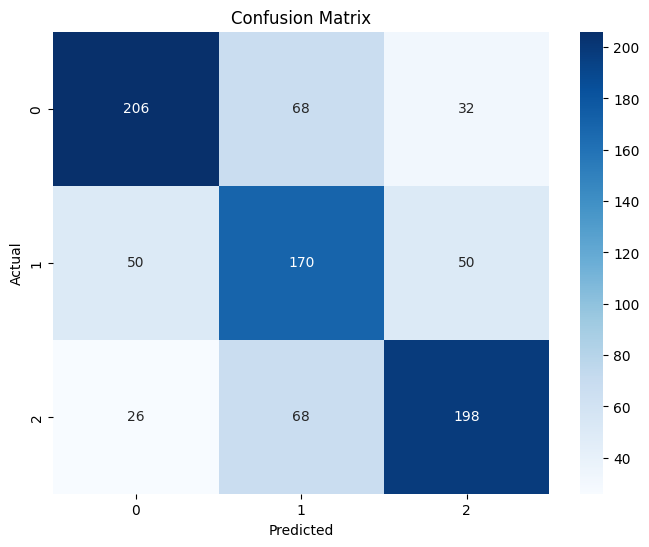

In [7]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
model.eval() #Evaluation mode

#For collecting all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images) #Forward Pass
        _, predicted = torch.max(outputs.data,1) #Choose class with highest score as prediction
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
#Confusion Matrix:
cm = confusion_matrix(all_labels, all_preds)
print(cm)
#Plotting:
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




## Conclusion:
The original goal of this project was to build a basic feedforward neural network to classify animal images (`dog`, `elephant`, `butterfly`) from the Animals-10 dataset. Throughout the development process, several key modifications were made to improve model performance, stability, and training correctness. Below is a complete list of all refinements and theoretical insights added along the way:

## 1. Model Architecture Enhancements

| Update | Description |
|--------|-------------|
| **Increased Neurons** | Changed architecture from a minimal 3-2-1 structure to a deeper network with more neurons in each layer, enabling the model to learn more complex patterns. |
| **Changed Activation to ReLU** | Replaced `Sigmoid` with `ReLU` in hidden layers for better convergence, especially in deeper networks. |
| **Reason** | ReLU avoids the vanishing gradient problem and speeds up training compared to Sigmoid. |
| **Final Output Layer** | For multi-class output, the final layer outputs raw logits instead of sigmoid probabilities. |

## 2. Loss Function Transition

### 🔄 Why We Changed the Loss Function

| Aspect                  | Details                                                                 |
|-------------------------|-------------------------------------------------------------------------|
| **Initial Choice**      | `Binary Cross Entropy (BCE)`                                            |
| **Issue**               | BCE is only suitable for **binary classification** tasks.               |
|                         | We are solving a **multi-class** problem (e.g., dog, butterfly, elephant). |
| **Problem Faced**       | Using BCE led to errors due to incorrect output and target shapes.      |
| **Final Choice**        | Switched to `CrossEntropyLoss()` — designed for multi-class classification. |
| **Result**              | Model now accepts raw logits and properly computes multi-class loss.    |

---

### 🧮 Key Differences

| Loss Type                  | Formula                                                                 | Notes                                                                 |
|---------------------------|-------------------------------------------------------------------------|-----------------------------------------------------------------------|
| **Binary Cross Entropy**  | `- [ y * log(ŷ) + (1 - y) * log(1 - ŷ) ]`                             | Expects probabilities (`ŷ` in [0, 1]), typically used with `Sigmoid`.|
| **Categorical Cross Entropy** | `-log( e^{z_k} / ∑ e^{z_j} )`<br> → `-log(Softmax(logits)[k])`        | Expects raw logits (no softmax needed). Best for multi-class output. |

---

> ✅ `CrossEntropyLoss()` is appropriate for classification problems where each input belongs to **exactly one class out of many**.


## 3. Training Loop and Optimizer

| Element | Explanation |
|---------|-------------|
| **Loss Tracking** | Implemented per-epoch loss reporting to observe convergence over time. |
| **Optimizer Used** | `Stochastic Gradient Descent (SGD)` with fixed learning rate. |
| **Epoch Intuition** | Explained epochs as "full passes through the dataset", allowing the model to iteratively refine weights. |
| **Overfitting Risk** | Discussed how increasing epochs too much can lead to overfitting on training data. |

## 4. Output Interpretation Fix

| Update | Explanation |
|--------|-------------|
| **Model Output (`ŷ`)** | Clarified that logits (not probabilities) should be passed to `CrossEntropyLoss`. |
| **Prediction Strategy** | After training, `argmax` was used to convert logits into predicted labels. |

## 5. Evaluation Improvements

| Topic | Details |
|-------|---------|
| **Confusion Matrix** | Used to evaluate class-wise performance. |
| **Accuracy Metric** | Implemented to check model's overall predictive success. |
| **Precision/Recall Discussion** | Discussed their role in imbalanced datasets (though not yet implemented). |

## 6. Dataset Management Fixes

| Fix | Description |
|-----|-------------|
| **Unbalanced Labels** | Identified severe class imbalance (e.g., 1446 dog images vs. 300 others). |
| **Solution** | Balanced the dataset by sampling an equal number (e.g., 1446) from each class. |
| **Manual Verification** | Counted class-wise samples to confirm balance before training. |

## Final Remarks

This iterative project evolved from a basic neural net to a well-structured, multi-class classification system with correct architectural, loss function, and dataset handling strategies. Each improvement addressed a specific challenge:

- Inappropriate loss function → switched to `CrossEntropyLoss`
- Vanishing gradients → switched to `ReLU`
- Class imbalance → fixed with balanced sampling
- Output mismatch → corrected with `argmax` + logits

> The process has strengthened both your understanding of neural networks and your practical skills in debugging and refining real-world ML systems.